In [1]:
import sys
sys.path.append('lsmat_utils')

In [2]:
from lsmat_to_graph import get_ports_pos, get_graph, get_cross_cones_for_given_plane, mesh_input_plane_periphery, get_list_N_cross_cones__cut_passes_center
from lsmat_generator import get_row_sparse_mat

In [3]:
import numpy as np
import pandas as pd
import networkx as nx

import matplotlib.pyplot as plt

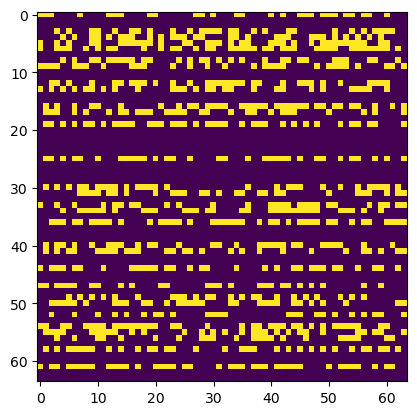

In [4]:
nx_in = 8
ny_in = 8
nx_out = 8
ny_out = 8
input_mat = np.zeros((nx_in*ny_in, nx_out*ny_out))

N_activated_outputs = 30
N_nonzero = 30*30
geq_or_leq = 'leq'

row_sparse_mask_mat,_ = get_row_sparse_mat(nx_in*ny_in, nx_out*ny_out, N_activated_outputs, N_nonzero, rand_seed=42)
plt.imshow(row_sparse_mask_mat, cmap='viridis')

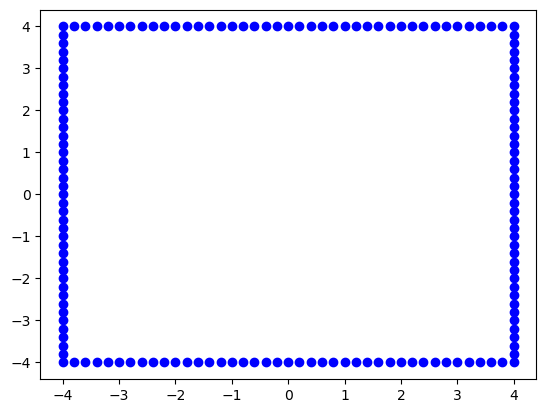

In [5]:
list_periphery_points = mesh_input_plane_periphery(row_sparse_mask_mat, nx_in,ny_in,nx_out,ny_out, steps_1_port=5)


# Extract x and y coordinates from the arrays
x_coords = [point[0] for point in list_periphery_points]
y_coords = [point[1] for point in list_periphery_points]

# Create a scatter plot
plt.scatter(x_coords, y_coords, marker='o', color='blue', label='Points')

In [6]:
len(list_periphery_points)

160

# sweep over different row sparse matrices

In [ ]:
import os
import re
import pandas as pd

import time

#### percentage_activated_outputs = 0.5, N_nonzero = 'all_satisfy_criteria'

In [ ]:
steps_1_port = 3
list_rand_seeds = np.random.randint(-2**31, 2**31, size=8, dtype=np.int32).tolist()
list_rand_seeds

In [ ]:
steps_1_port = 3

for percentage_activated_outputs in [0.5]:

    param_grid = {
        'nx_in': [6, 8, 10, 12, 16, 20, 24, 28, 32, 36, 40, 48, 56, 64],
        'percentage_activated_outputs': [percentage_activated_outputs],
        'mat_density': ['all_satisfy_criteria']
    }
    
    
    
    #os.makedirs(model_save_dir, exist_ok=True)
    # path, local sparse matrices
    #spreadsheet_path = f"maxC_vs_N__local_sparse_matrices__steps_1_port=5.csv"
    spreadsheet_path = f"C_vs_N__row_sparse_matrices__steps_1_port={steps_1_port}.csv"
    if os.path.exists(spreadsheet_path):
        df_results = pd.read_csv(spreadsheet_path)
    else:
        df_results = pd.DataFrame()
    
    
    for nx_in in param_grid['nx_in']:
        for rand_seed in list_rand_seeds:
    
            params = {
                'nx_in': nx_in,
                'ny_in': nx_in,
                'nx_out': nx_in,
                'ny_out': nx_in,
                'percentage_activated_outputs': param_grid['percentage_activated_outputs'][0],
                'mat_density': param_grid['mat_density'][0],
                'steps_1_port': steps_1_port,
                'rand_seed': rand_seed
            }
            #print("Processing with parameters:", params)
    
    
            t_start = time.time()
            
            nx_in = params['nx_in']
            ny_in = params['ny_in']
            nx_out = params['nx_out']
            ny_out = params['ny_out']
            N_activated_outputs = int(np.ceil(params['percentage_activated_outputs'] * nx_out*ny_out))

            if params['mat_density'] == 'all_satisfy_criteria':
                N_nonzero = 'all'
                row_sparse_mat, N_satisfy_threshold = get_row_sparse_mat(nx_in*ny_in, nx_out*ny_out, N_activated_outputs, N_nonzero, rand_seed)
                # compute the actual matrix density
                params['mat_density'] = N_satisfy_threshold / (nx_in*ny_in * nx_out*ny_out)
            elif isinstance(params['mat_density'], float):
                N_nonzero = int(np.ceil(params['mat_density'] *nx_in*ny_in *nx_out*ny_out))
                row_sparse_mat, N_satisfy_threshold = get_row_sparse_mat(nx_in*ny_in, nx_out*ny_out, N_activated_outputs, N_nonzero, rand_seed)

            
            list_N_cross_cones, list_cut_length = get_list_N_cross_cones__cut_passes_center(row_sparse_mat, nx_in,ny_in,nx_out,ny_out,
                                                                                            threshold=0.01, steps_1_port=params['steps_1_port'])
            # this list contains the numbers of cross cones for ALL valid cuts



            params_json = params
            params_json['N_entries_satisfy_threshold'] = N_satisfy_threshold
            params_json['N_nonzero'] = N_nonzero
    
            array_C = np.array(list_N_cross_cones)
            array_cut_length = np.array(list_cut_length)
            params_json['max(C)'] = np.max(array_C)
            params_json['avg(C)'] = np.mean(array_C)
            params_json['std(C)'] = np.std(array_C, ddof=0)
            idx_max_C = np.where(array_C == np.max(array_C))[0] # could be multiple indices associated with the same max value
            #params_json['cut_length_for_max(C)'] = array_cut_length[idx_max_C].tolist()
            params_json['cut_length_for_max(C)'] = ', '.join(f"{x:.4f}" for x in array_cut_length[idx_max_C].tolist()) # save the list in a single string
    
    
            # thickness = N_cross_cones / cut_length
            array_thickness = array_C / array_cut_length
            params_json['max(thickness)'] = np.max(array_thickness)
            idx_max_thickness = np.where(array_thickness == np.max(array_thickness))[0] # could be multiple indices associated with the same max value
            #params_json['cut_length_for_max(thickness)'] = array_cut_length[idx_max_thickness].tolist()
            params_json['cut_length_for_max(thickness)'] = ', '.join(f"{x:.4f}" for x in array_cut_length[idx_max_thickness].tolist()) # save the list in a single string
            #params_json['C_for_max(thickness)'] = array_C[idx_max_thickness].tolist()
            params_json['C_for_max(thickness)'] = ', '.join(f"{x:.4f}" for x in array_C[idx_max_thickness].tolist()) # save the list in a single string
    
    
            
            t_end = time.time()
            time_consumption = (t_end-t_start)
            params_json['time_consumption'] = time_consumption
            print(time_consumption) # unit: seconds
            
            df_results = pd.concat([df_results, pd.DataFrame([params_json])], ignore_index=True)
            df_results.to_csv(spreadsheet_path, index=False)